In [24]:
from __future__ import division
from pyoperators import pcg
from pysimulators import profile

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
from qubic import QubicSkySim as qss
import sys
sys.path.append('/Users/mregnier/Desktop/PhD Regnier/mypackages')


import Acquisition as Acq

# Display packages
import healpy as hp
import matplotlib.pyplot as plt

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# General packages
import numpy as np
import pysm3
import warnings
from qubic import QubicSkySim as qss
import pysm3.units as u
from importlib import reload
from pysm3 import utils

from qubic import SpectroImLib as sp
from importlib import reload
import gc
import copy
from pyoperators import *
import myPCG as mypcg


# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator)

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
# %matplotlib inline

## Now QUBIC and Planck acquisitions used for reconstruction

def integration(nu_min, nu_max, Nintegr, sky_config, d, fwhm_subbands = None):
    print(f'Integration from {nu_min:.2f} to {nu_max:.2f} GHz with {Nintegr} steps')
    obj = Acq.QubicIntegrated(d, Nsub=Nintegr, Nrec=Nintegr)
    if Nintegr == 1:
        allnus = np.array([np.mean([nu_min, nu_max])])
    else:
        allnus = np.linspace(nu_min, nu_max, Nintegr)
    m = obj.get_PySM_maps(sky_config, nus=allnus)
    
    if fwhm_subbands is not None:
        for i in range(Nintegr):
            C = HealpixConvolutionGaussianOperator(fwhm=fwhm_subbands[i])
            m[i] = C(m[i])
    
    return np.array([np.mean(m, axis=0)])


# # %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [25]:
import pickle

with open('sol_with_noise.pickle', 'rb') as f:
    solnoisy, okpix = pickle.load(f)

In [26]:
with open('sol_without_noise.pickle', 'rb') as f:
    solnoiseless, okpix = pickle.load(f)

In [29]:
residuals = solnoisy - solnoiseless

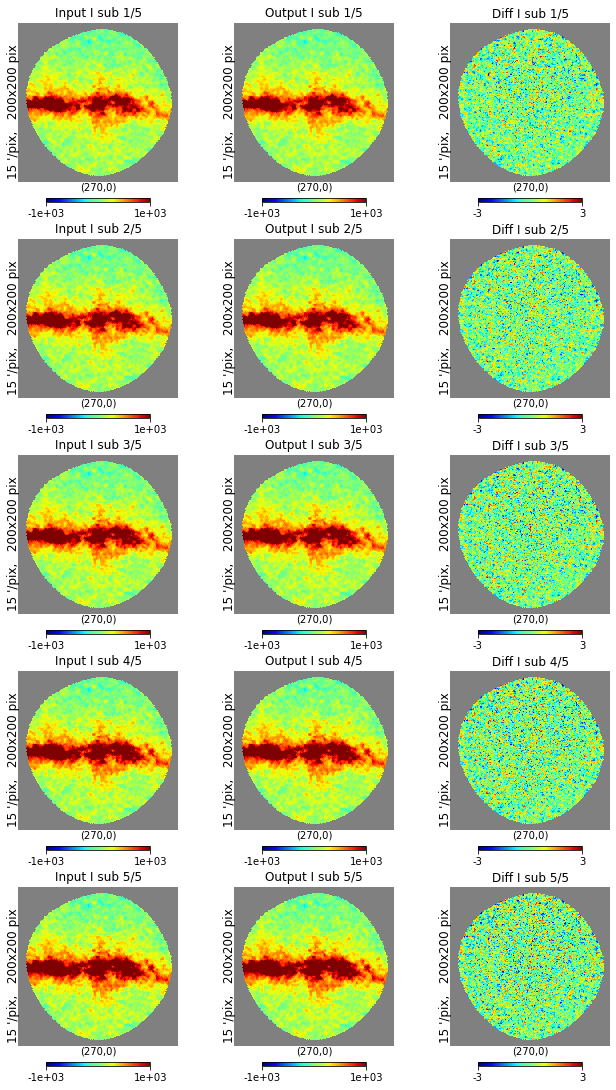

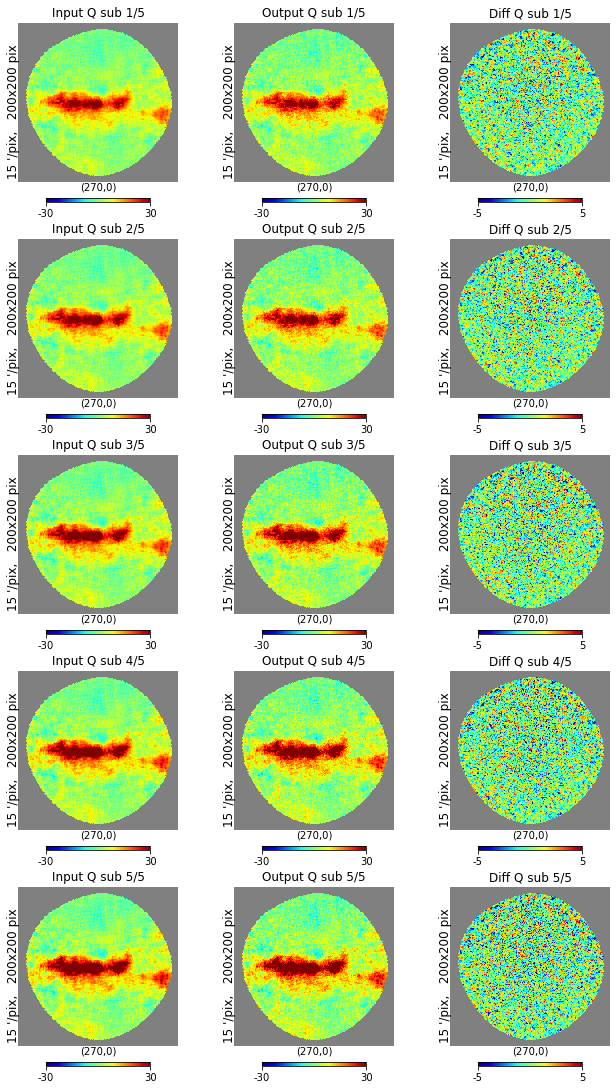

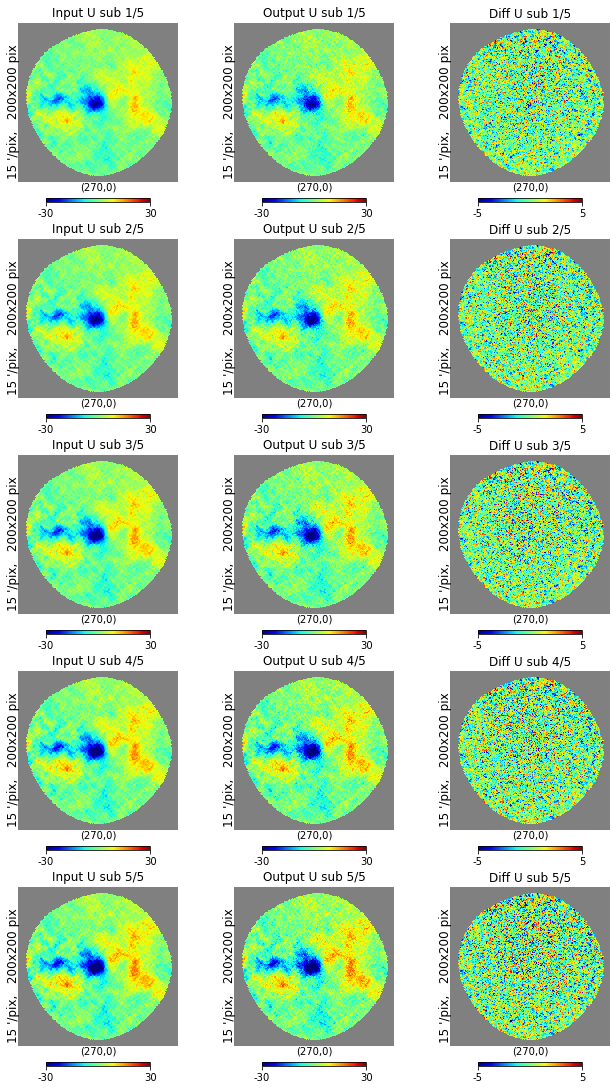

In [27]:
center = np.array([270, 0])
nside = 256
stk = ['I', 'Q', 'U']

for s in range(3):
    plt.figure(figsize=(9, 15))  
    if s==0:
        v = 1000
        r = 3
    else:
        v = 30
        r = 5
    for i in range(5):
        mymap_noisy = np.zeros(12*nside**2) + hp.UNSEEN
        mymap_noiseless = np.zeros(12*nside**2) + hp.UNSEEN
        mymap_noisy[okpix] = solnoisy[i,:,s]
        mymap_noiseless[okpix] = solnoiseless[i,:,s]
        mydiff = mymap_noisy - mymap_noiseless
        mydiff[~okpix] = hp.UNSEEN
        hp.gnomview(mymap_noiseless, rot=center, sub=(5, 3, 3*i+1), title='Input {} sub {}/{}'.format(stk[s], i+1, 5), min=-v, max=v, reso=15, cmap='jet')
        hp.gnomview(mymap_noisy, rot=center, sub=(5, 3, 3*i+2), title='Output {} sub {}/{}'.format(stk[s], i+1, 5), min=-v, max=v, reso=15, cmap='jet')
        hp.gnomview(mydiff, rot=center, sub=(5, 3, 3*i+3), title='Diff {0:} sub {1:}/{2:}'.format(stk[s], i+1, 5), min=-r, max=r, reso=15, cmap='jet')
    tight_layout()
  

In [32]:
residuals.shape

(5, 27107, 3)

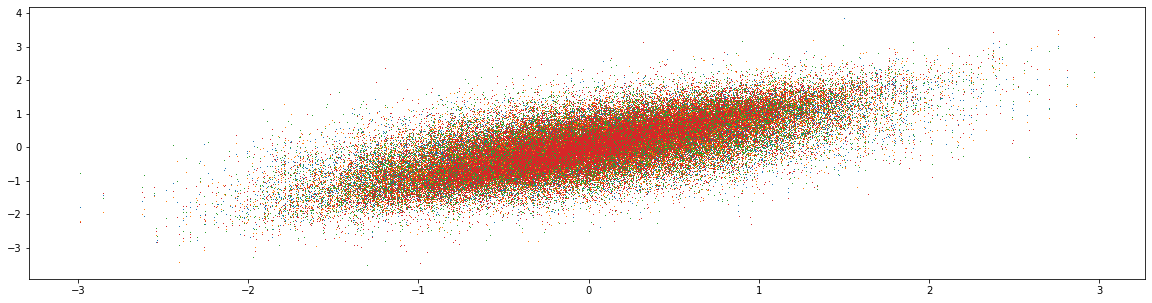

In [111]:
for i in range(1, np.shape(residuals)[0]):
    plot(residuals[0,:,0], residuals[i,:,0], ',')


[[0.49521032 0.37099516 0.38396309 0.39405623 0.40941083]
 [0.37099516 0.52345772 0.39974269 0.40909858 0.4244318 ]
 [0.38396309 0.39974269 0.585029   0.44320238 0.45116916]
 [0.39405623 0.40909858 0.44320238 0.63908457 0.48059284]
 [0.40941083 0.4244318  0.45116916 0.48059284 0.70167718]]

[0.13804973 0.15787785 0.17915389 0.20276977 2.26660755]

[[-0.71480772 -0.37967292 -0.34593625  0.25100047 -0.40277199]
 [ 0.69882464 -0.35824681 -0.36320131  0.2763845  -0.41832973]
 [-0.02452953  0.82211387 -0.0831361   0.34146524 -0.44723255]
 [ 0.00649044 -0.21504576  0.84912539  0.1096916  -0.46975208]
 [ 0.00708682  0.07342886 -0.14313411 -0.85555807 -0.49202743]]


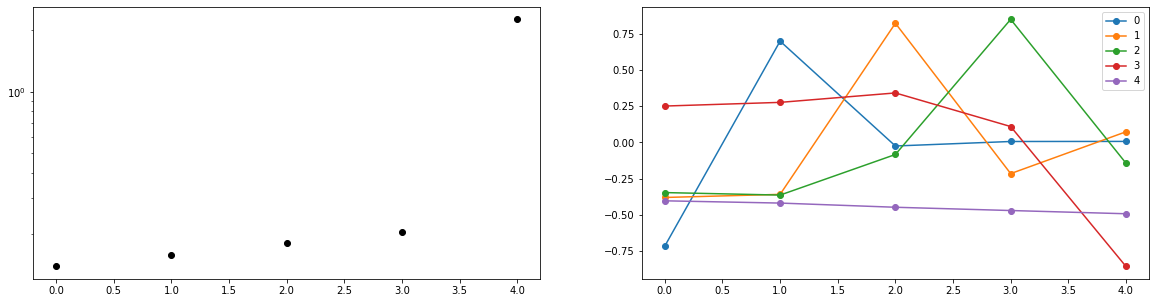

In [125]:
i=0
mycov = np.cov(residuals[:,:,i])
print(mycov)
print()
w, v = np.linalg.eigh(mycov)
print(w)
print()
print(v)
subplot(1,2,1)
plot(w, 'ko')
yscale('log')
subplot(1,2,2)
for i in range(len(w)):
    plot(v[:,i], 'o-', label=i)
legend()


[[0.49521032 0.37099516 0.38396309 0.39405623 0.40941083]
 [0.37099516 0.52345772 0.39974269 0.40909858 0.4244318 ]
 [0.38396309 0.39974269 0.585029   0.44320238 0.45116916]
 [0.39405623 0.40909858 0.44320238 0.63908457 0.48059284]
 [0.40941083 0.4244318  0.45116916 0.48059284 0.70167718]]

[[2.48950206 1.40132406 1.39153147 1.40880558 1.46281724]
 [1.40132406 2.64257676 1.43991096 1.45575951 1.51677182]
 [1.39153147 1.43991096 2.8477627  1.54532689 1.57824333]
 [1.40880558 1.45575951 1.54532689 3.03013379 1.68258839]
 [1.46281724 1.51677182 1.57824333 1.68258839 3.35576031]]

[[2.42966271 1.34462857 1.32119811 1.34052745 1.39820916]
 [1.34462857 2.5978478  1.41878704 1.37710744 1.46937511]
 [1.32119811 1.41878704 2.76668745 1.47980294 1.5042683 ]
 [1.34052745 1.37710744 1.47980294 2.95249834 1.61007972]
 [1.39820916 1.46937511 1.5042683  1.61007972 3.30261573]]


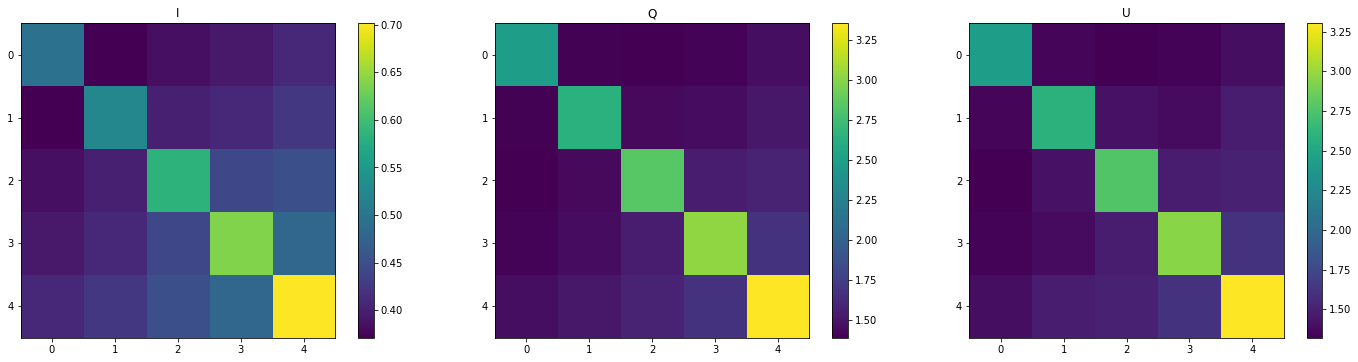

In [96]:
mycov = np.zeros((3,5,5))
rc('font', size=10)
rc('figure', figsize=(20, 5))
for i in range(3):
    subplot(1,3,i+1)
    mycov[i,:,:] = np.cov(residuals[:,:,i])
    imshow(mycov[i,:,:])
    print()
    print(mycov[i,:,:])
    title(stk[i])
    colorbar()
tight_layout()

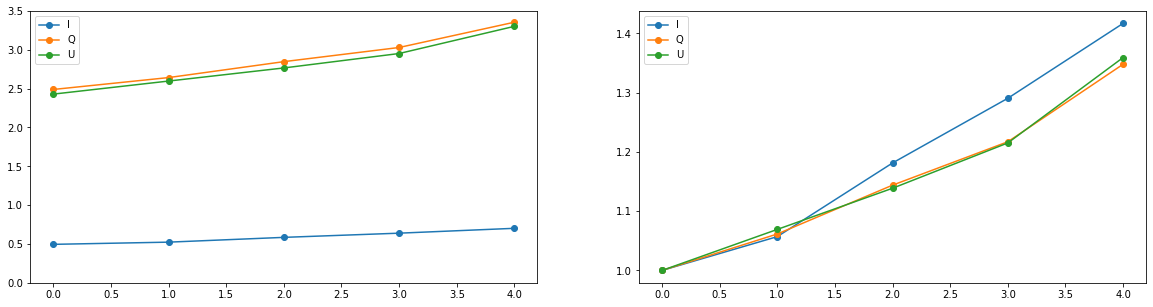

In [104]:
subplot(1,2,1)
for i in range(3):
    plot(np.diag(mycov[i,:,:]), 'o-', label=stk[i])
legend()
ylim(0,3.5)

subplot(1,2,2)
for i in range(3):
    plot(np.diag(mycov[i,:,:]) / np.diag(mycov[i,:,:])[0], 'o-', label=stk[i])
legend()



[[1.         0.53520787 0.50958296 0.50050438 0.49359429]
 [0.53520787 1.         0.52921277 0.4972401  0.50164537]
 [0.50958296 0.52921277 1.         0.51776061 0.49764109]
 [0.50050438 0.4972401  0.51776061 1.         0.51561261]
 [0.49359429 0.50164537 0.49764109 0.51561261 1.        ]]

[[1.         0.53520787 0.50958296 0.50050438 0.49359429]
 [0.53520787 1.         0.52921277 0.4972401  0.50164537]
 [0.50958296 0.52921277 1.         0.51776061 0.49764109]
 [0.50050438 0.4972401  0.51776061 1.         0.51561261]
 [0.49359429 0.50164537 0.49764109 0.51561261 1.        ]]

[[1.         0.53520787 0.50958296 0.50050438 0.49359429]
 [0.53520787 1.         0.52921277 0.4972401  0.50164537]
 [0.50958296 0.52921277 1.         0.51776061 0.49764109]
 [0.50050438 0.4972401  0.51776061 1.         0.51561261]
 [0.49359429 0.50164537 0.49764109 0.51561261 1.        ]]


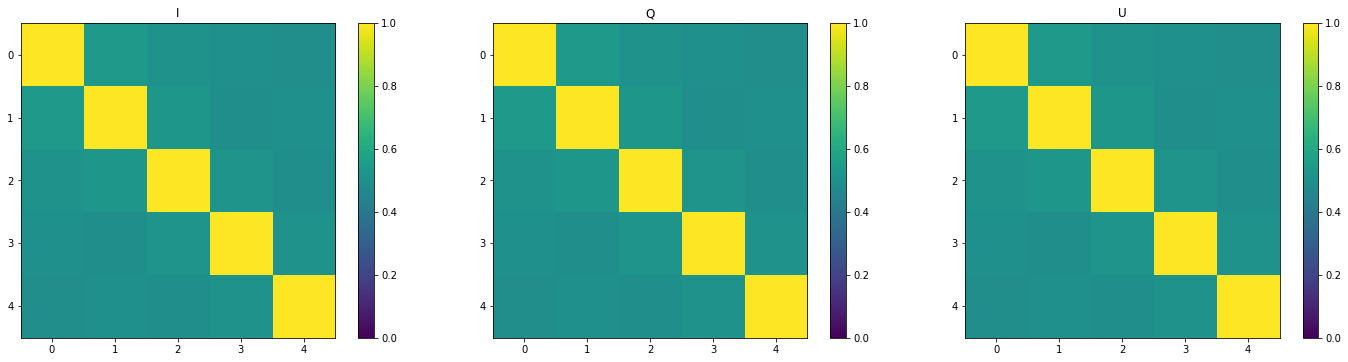

In [57]:
rc('font', size=10)
rc('figure', figsize=(20, 5))
for i in range(3):
    subplot(1,3,i+1)
    imshow(np.corrcoef(residuals[:,:,2]), vmin=0, vmax=1)
    print()
    print(np.corrcoef(residuals[:,:,2]))
    title(stk[i])
    colorbar()
tight_layout()

In [58]:
residuals.shape

(5, 27107, 3)

In [74]:
res = np.transpose(residuals, axes=(2,0,1))
res.shape

(3, 5, 27107)

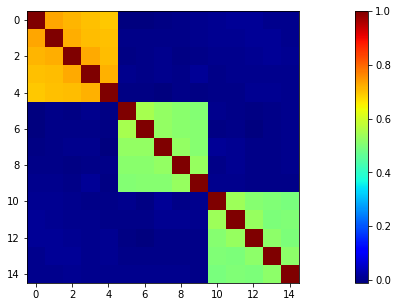

In [83]:
bla = np.reshape(res, (15, 27107))
imshow(np.corrcoef(bla), cmap='jet')
colorbar()

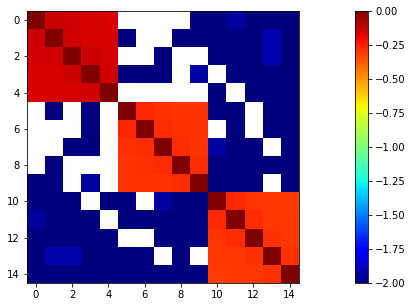

In [82]:
bla = np.reshape(res, (15, 27107))
imshow(np.log10(np.corrcoef(bla)), vmin=-2, vmax=0, cmap='jet')
colorbar()